# transformer
<img src='../img/transformer.svg' alt='transformer' width=400><br>
* 基于编码器-解码器架构来处理序列对
* 跟使用注意力的seq2seq不同Transformer是纯基于注意力(self-attention)

## 多头注意力
* 对于同一key,value,query希望抽取不同的信息例如短距离关系和长距离关系
* 多头注意力使用h个独立的注意力池化
* 合并各个头输出得到最终输出

<img src='../img/multi-head-attention.svg' alt='multi-head-attention' width=400><br>

## 有掩码的多头注意力
attention是可以看到后面所有信息的，这对于编码来说无所谓，但是解码不应该考虑元素之后的元素<br>
通过掩码实现，就是计算$x_i$输出时，假装当前序列长度为i

## 基于位置的前馈神经网络
* 将输入形状由(b,n,d)变换成(bn,d)
* 作用两个全连接层
* 输出形状由(bn,d)变化回(b,n,d)
* 等价于两层核窗口为1的一位卷积层
* 对d做映射

## 层归一化
<img src='./image/layerNorm.jpg' alt='layerNorm' width=400><br>
* 批量归一化对每个特征/通道里元素进行归一化
  * 不适合序列长度会变的NLP应用
* 层归一化对每个样本里的元素进行归一化
  
## 信息传递
* 编码器中的输出$y_1,...,y_n$
* 将其作为解码中第i个transfomer块中多头注意力的key和value
  * query来自目标序列
* 意味着编码器和解码器中的块的个数和输出维度都是一样的

## 预测
* 预测第$t+1$个输出时
* 解码器中输入前t个预测值
  * 在自注意力中，前t个预测值作为key和value，第t个预测值还作为query
<img src='./image/predict.jpg' alt='layerNorm' width=400><br>


## 多头注意力实现

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

class MultiHeadAttention(d2l.Module):
    """Multi-head attention.

    Defined in :numref:`sec_multihead-attention`"""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias) # 自动根据输入数据的形状推断输入维度并初始化权重。
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # 转换为多头
        queries = self.transpose_qkv(self.W_q(queries))# 先做了一次映射后拆分成多头
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave( # 因为这里是多头的，所以要重复头个数个
                valid_lens, repeats=self.num_heads, dim=0) # batch*head个相当于batch，进入之后在乘seqlen正常运算

        # Shape of output: (batch_size * num_heads, no. of queries, num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat) # 输出线性变换层 batch,q,hidden

    def transpose_qkv(self, X): # 拆分成多头
        # X：(batch,no. q/k/v, head, hidden/head )
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
       
        # X：(batch, head, qkv, hidden/head)
        X = X.permute(0, 2, 1, 3)
        # 输出 (batch*numheads, number, hidden/head)
        return X.reshape(-1, X.shape[2], X.shape[3])
    

    def transpose_output(self, X):
        # X: (batch, head, num q, hidden/head)
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        # X: (batch, num q, head, hidden/head)
        X = X.permute(0, 2, 1, 3)
        # X: (batch,num q, hidden)
        return X.reshape(X.shape[0], X.shape[1], -1)


测试


In [2]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
attention.eval()
batch_size, num_queries, num_kvpairs, valid_len = 2, 4, 6,torch.tensor([3, 2])

X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))

attention(X, Y, Y, valid_len).shape


torch.Size([2, 4, 100])

## 实现Transformer

In [3]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

### 基于位置的前馈神经网络

In [4]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):# pytorch实现种默认实用最后的维度当作计算的维度
        return self.dense2(self.relu(self.dense1(X)))# 输入为三维

In [5]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()

ffn(torch.ones((2, 3, 4))).shape # 可以看到影射了最后一维

torch.Size([2, 3, 8])

## 归一化层
对不不同的维度的层归一化


In [6]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


使用残差连接和层归一化

In [7]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [8]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## 编码器

In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

不改变输入的形状

In [10]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

完整的编码器

In [11]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 对输入X进行嵌入（embedding），并乘以sqrt(num_hiddens)进行缩放
        # 这样做是为了让嵌入的方差与位置编码一致
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))

        # 存储每层的attention权重
        self.attention_weights = [None] * len(self.blks) 
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights # 每层的参数，形状为batch*head, q, v，q等于seqlen 这个例子中v也等于seqlen
            # 这里的是dotproduct中的权重
        return X

创建一个两层的编码器

In [12]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2,
                             0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

## 解码器

In [ ]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None: # 对应层的每次的输出
            key_values = X
        else:
            # 预测时，并不使用iter所以pytorch不会丢弃中间状态
            key_values = torch.cat((state[2][self.i], X), axis=1) # 如果是predict的话要不断地存在里面，在seqlen上做concat
        state[2][self.i] = key_values # 更新缓存 pytorch会自动的丢弃所有的非参数变量
        if self.training: # torch中默认有的成员， model.train()
            batch_size, num_steps, _ = X.shape # 训练时每个位置只能看到当前位置之前的内容
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange( # 遮蔽的不是hidden 而是validlens的维度，在最后求权重加和的时候去掉后面的v对前面的影响
                1, num_steps + 1, device=X.device).repeat(batch_size, 1) # 形状为(batch, seq_len)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens) # 包含了masksoftmax操作
        # 因为在操作中会映射回numhiddens
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        # 所有的解码器用的都是编码器最后一层的输出
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens) # 注意这里使用的是编码器的输出的有效长度
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [14]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [15]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.029, 11224.3 tokens/sec on cuda:0


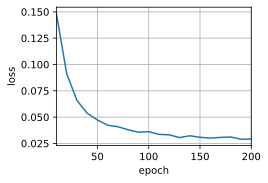

In [16]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [17]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


可视化注意力

In [18]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

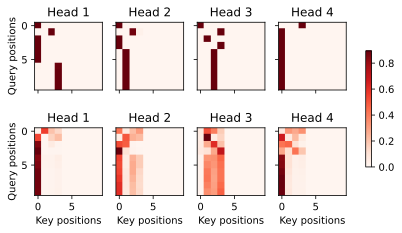

In [19]:
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

In [21]:
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step
    for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

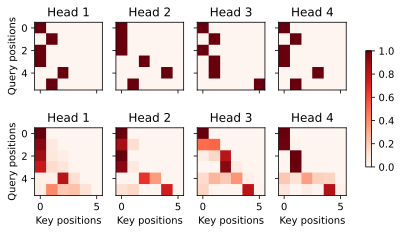

In [22]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))